# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. Les binômes seront classés par taux de reconnaissance décroissant, les premiers ayant 8 points accordés, les autres binômes ayant une note suivant une décroissance linéaire.

Le notebook sera déposé sur la plateforme moodle du cours.

## Imports

In [2]:
import tensorflow
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

print(tensorflow.version.VERSION)
# Ajouter les imports nécessaires

2.4.1


## Chargement des données pour l'entraînement

On utilise le module `pandas`, il facilite grandement le chargement de fichier CSV, en les lisant sous-forme de matrices appelées **Dataframes**.

L'utilisation du paramètre `dtype` est obligatoire pour indiquer à `pandas` de charger le contenu des cases sous la forme de chaînes de caractères. Cela évite une transformation pour obtenir les étiquettes des classes qui doit obligatoirement être de ce type là.

In [3]:
trainData = pd.read_csv("train.csv", dtype="str")
validData = pd.read_csv('valid.csv', dtype="str")
print(trainData)

              image_name             relative_path class_label
0      basket_052681.png  basket/basket_052681.png           0
1      basket_028248.png  basket/basket_028248.png           0
2      basket_050738.png  basket/basket_050738.png           0
3      basket_034414.png  basket/basket_034414.png           0
4      basket_091738.png  basket/basket_091738.png           0
...                  ...                       ...         ...
74995    hand_241467.png      hand/hand_241467.png           4
74996    hand_052619.png      hand/hand_052619.png           4
74997    hand_168727.png      hand/hand_168727.png           4
74998    hand_285523.png      hand/hand_285523.png           4
74999    hand_263562.png      hand/hand_263562.png           4

[75000 rows x 3 columns]


## Génération de données

Nous utilisons l'outil de génération de données `ImageDataGenerator`pour faciliter la manipulation du Dataframe.
Comme les données de validation sont stockées dans un second fichier, il n'est pas nécessaire d'utiliser un `validation_split`.

In [4]:
trainImageGenerator = ImageDataGenerator(
    validation_split=0
)

## Modèle

Selu est légèrement meilleur que Relu dans notre cas. Sigmoid ne fonctionne pas du tout.
### InputLayer
Sa dimension correspond à la résolution des images utilisées.

### Reshape
On modifie la dimension pour convertir toutes les images qui étaient en couleur en niveau de gris.

### Conv2D
On réduit la taille du layer en moyennant les pixels d'un carré 3x3.

### MaxPooling2D
Sous-échantillonage en ne conservant que la valeur maximum des sous-matrices (2x2).  Une taille de sous-matrice plus importante entraienerait une trop grosse perte d'informations.

### Dropout
Cette couche permet d'introduire de l'aléatoire dans le modèle pour le faire évoluer. On ignore certains neurones pour voir introduire des variations de résultats. Ici *25%* des neurones sont abandonnés. 

## Flatten
Permet de changer la dimension pour atteindre une dimension.

### Dense
Sa dimension est (5), car notre modèle détermine une classe parmis 5 disponibles.
On utilise la fonction `softmax` car nous souhaitons sélectionner une seule classe parmis celles disponnibles. On séléctionne celle avec la plus grande probabilité.

In [5]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(28, 28)), # Résolution des images
        keras.layers.Reshape((28, 28, 1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='selu'),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='selu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(5, activation='softmax')
    ]
)

## Compilation du modèle

### Optimizer
Pour séléctionner la fonction d'optimisation, nous avons décidé de bloquer les autres paramètres de la simulation, et de conserver la fonction qui obtient les meilleurs résultats en 10 epochs.

| Fonction | Validation accuracy (approx.) |
| --- | --- |
| SGD | 92% |
| Adam | 92% |
| Adagrad | 93% |
| Ftrl | 89% |
| RMSprop | 91% |
| Adadelta | 61% |
| Nadam | 92% |

Nous avons donc décidé de converver le `Adam`.

In [6]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 4

## Répartition des données

In [7]:
# Images utilisées pour l'entrainement
train_images = trainImageGenerator.flow_from_dataframe(
    dataframe=trainData, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=750,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
)

# Images utilisées pour la validation
validation_images = trainImageGenerator.flow_from_dataframe(
    dataframe=validData, # Données provenant de pandas pour la validation
    directory="images",
    x_col="relative_path",
    y_col="class_label",
    class_mode="categorical",
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=750,
    validate_filenames=False # Pas de vérification des fichiers pour gagner du temps
)

Found 75000 non-validated image filenames belonging to 5 classes.
Found 25000 non-validated image filenames belonging to 5 classes.


## Entrainement du modèle

Pour entraîner le modèle, nous utilisons les images provenant du fichier d'entrainement. Et nous utilisons celle de l'autre fichier pour faire la validation de la progression.

Nous avons choisis de faire seulement 5 epochs, au-delà la progression ne semble pas très élevée.

In [9]:
history = model.fit(train_images, validation_data=validation_images, epochs=5, verbose=1)

Epoch 1/5
100/100 [==============================] - 63s 627ms/step - loss: 0.3306 - categorical_accuracy: 0.9013 - val_loss: 0.2935 - val_categorical_accuracy: 0.9140
Epoch 2/5
100/100 [==============================] - 59s 590ms/step - loss: 0.3139 - categorical_accuracy: 0.9048 - val_loss: 0.2995 - val_categorical_accuracy: 0.9122
Epoch 3/5
100/100 [==============================] - 59s 587ms/step - loss: 0.2965 - categorical_accuracy: 0.9096 - val_loss: 0.2845 - val_categorical_accuracy: 0.9162
Epoch 4/5
100/100 [==============================] - 59s 590ms/step - loss: 0.2812 - categorical_accuracy: 0.9143 - val_loss: 0.2763 - val_categorical_accuracy: 0.9175
Epoch 5/5
100/100 [==============================] - 59s 589ms/step - loss: 0.2699 - categorical_accuracy: 0.9168 - val_loss: 0.2845 - val_categorical_accuracy: 0.9182


## Affichage des résultats

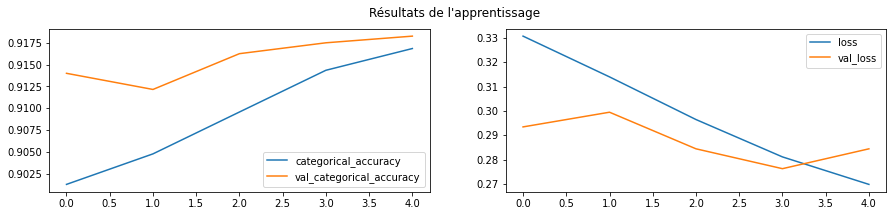

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle("Résultats de l'apprentissage")
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.legend(['categorical_accuracy', 'val_categorical_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['loss', 'val_loss'])

## Exemple de classification par le modèle

Pour afficher quelques exemples nous allons réutiliser les données utilisées lors de la validation. On demande au modèle de prédire la classe des images, puis on extrait une partie de ces résultats. Enfin on affiche le résultat après l'avoir convertie en texte plus explicite.

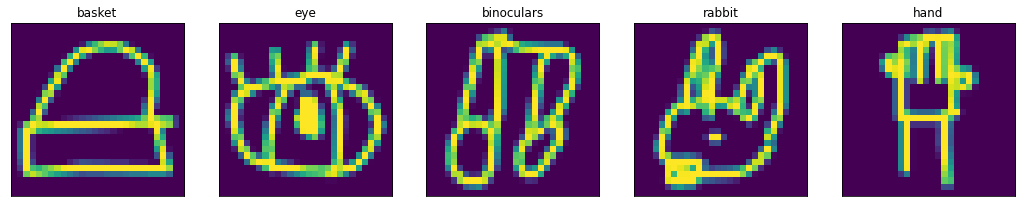

In [11]:
classes = ["basket", "eye", "binoculars", "rabbit", "hand"]

def load(filename):
    np_image = Image.open(filename)
    np_image = image.img_to_array(np_image)
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(1, 5 ,i+1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    prediction = model.predict(load('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0]))
    prediction = np.argmax(prediction, axis = 1)[0]
    plt.title(classes[prediction])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    

## Sauvegarde du modèle

On utilise le format **HDF5** pour stocker le modèle, ce format est pratique car il permet de stocker l'architecture du modèle, les poids ainsi que les informations de compilation du modèle.

In [12]:
model.save("pouly_zangla_classifier.h5")